authors: Noah Jones and Daniel Low



## Imports

In [21]:
# !pip install -q lightgbm==3.3.3
# !pip install -q contractions==0.1.73
# !pip install --user -U nltk==3.8.1

In [118]:
import numpy as np
import random
import pandas as pd

import os 
import re

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,StratifiedKFold

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold

from sklearn.naive_bayes import ComplementNB
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import (
    auc,
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    f1_score,
    confusion_matrix,
)
from sklearn.compose import ColumnTransformer
from sklearn.base import clone

import contractions
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielmlow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Datasets and set parameters

In [175]:
pd.set_option("display.max_columns", None)
# pd.options.display.width = 0


on_colab = False

if on_colab:
    from google.colab import drive
    project_name = 'project_name'
    drive.mount('/content/drive')
    input_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/input/'
    output_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/output/'
else:
    input_dir = './data/input/final_datasets/'
    output_dir = './data/output/performance/'


In [262]:
# load data
train = pd.read_csv(input_dir+'train.csv', index_col=0)
val = pd.read_csv(input_dir+'val.csv', index_col=0)
test = pd.read_csv(input_dir+'test.csv', index_col=0)
print(train.shape, test.shape)

# We'll use CV for hyperparameter tuning, so we'll concatenate the train and val data
train = train.append(val).reset_index(drop=True)
train = train.sample(frac=1).reset_index(drop=True)

X_train_text = train['content']
X_train_metadata = train[['type_tag_content','contact_size','reputation','type']]
y_train = train['label'].values

X_test_text = test['content']
X_test_metadata = test[['type_tag_content','contact_size','reputation','type']]
y_test = test['label'].values

print(X_train_text.shape, X_train_metadata.shape, y_train.shape, X_test_text.shape, X_test_metadata.shape, y_test.shape)



(6478, 10) (1279, 11)
(7170,) (7170, 4) (7170,) (1279,) (1279, 4) (1279,)


## Helper Functions

In [139]:
SEED_VALUE = 10
np.random.seed(SEED_VALUE)

kf = KFold(n_splits=5, shuffle=False, random_state=None)


In [254]:
import metrics_report # local script
from sklearn import metrics
def save_results_df(pipeline_gridsearch, X_train, y_train, X_test, y_test, model_name, output_dir= './', ts = None, results = {}):
    
    best_params = {}
    for k,v in pipeline_gridsearch.best_params_.items():
        best_params['estimator__'+k] = v

    pipeline_gridsearch.set_params(**best_params)
    print('training with best params...')
    pipeline_gridsearch.fit(X_train, y_train)
    print('done. evaluating on test set')
    y_pred_proba = pipeline_gridsearch.predict_proba(X_test)

    y_pred_proba_1 = y_pred_proba[:,1]
    y_pred = [np.argmax(n) for n in y_pred_proba]
    clf_report_sklearn = metrics.classification_report(y_test,y_pred, output_dict=False) #evaluate #different than the output of cross_validate() above.
    cm_df_meaning, cm_df, cm_df_norm = metrics_report.cm(y_test, y_pred, output_dir, model_name, ts, save=True)
    clf_report = metrics_report.classification_report(y_test,y_pred,y_pred_proba_1, output_dir, model_name, ts)
    # scores = cross_validate(pipe, X, y, scoring=['f1','precision', 'recall'], cv=cv, return_train_score=False) #train and evaluate    
    results[model_name] = {
        'clf_report': clf_report,
        'cm_df_meaning': cm_df_meaning,
        'cm_df': cm_df,
        'cm_df_norm': cm_df_norm,
        'clf_report_sklearn': clf_report_sklearn

    }

    return results




def preprocess(string):
    string = string.replace('|body|',"")
    string = re.sub(r"http\S+", "", string)
    string = re.sub(r"www+", "", string)
    #fix contractions
    string = contractions.fix(string,slang=False)
    return string

def custom_tokenizer(string):
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(string)
    return words


# def compute_metrics(labels : int, pred_labels : int, pred_scores : float):
#     roc_auc_pred_score = roc_auc_score(labels, pred_scores)
#     precisions, recalls, thresholds = precision_recall_curve(labels,
#                                                              pred_scores)
#     fscore = (2 * precisions * recalls) / (precisions + recalls)
#     fscore[np.isnan(fscore)] = 0
#     ix = np.argmax(fscore)
#     threshold = thresholds[ix].item()
#     pr_auc = auc(recalls, precisions)
#     tn, fp, fn, tp = confusion_matrix(labels, pred_labels, labels=[0, 1]).ravel()
    
    
    
    
    
#     result = {'ROC_AUC': roc_auc_pred_score,
#               'Average Precision': pr_auc,
#               'Recall': recalls[ix].item(),
#               'Precision': precisions[ix].item(), 'F1': fscore[ix].item(),
#               'TN': tn.item(), 'FP': fp.item(), 'FN': fn.item(), 'TP': tp.item(),
#               'Best_threshold' : threshold
#               }
#     return result
    
# def get_final_estimator(grid_search_object, old_pipeline, random_state, train_df=train):
#     '''Uses the grid search object parameters to train a new preprocessor and estimator and optionally does bootstrap traing'''
#     pipeline = clone(old_pipeline)
#     pipeline.set_params(**grid_search_object.best_params_)
#     if random_state >= 0:
#         pipeline.set_params(lgbm__random_state=random_state)
#         pipeline.fit(train_df, train_df['label'])
#     else:
#         pipeline.fit(train_df, train_df['label'])

#     return pipeline

# def create_output_df(metric_tup):
#     metrics, label_list = metric_tup
#     new_list = []
#     for label_output in label_list:
#         metrics, label_output
#         y_true, y_class, y_pred = label_output

#         if len(metrics[next(iter(metrics))]) == 1:
#             results_df = pd.DataFrame.from_records([metrics])
#         else:
#             results_df = pd.DataFrame(metrics)
#         label_df = pd.DataFrame({'y_true':y_true,'y_class':y_class,'y_pred':y_pred})
#         new_list.append(label_df)
#     return results_df, new_list

    
# def results_on_test(grid_search_object, pipeline, csv_file=True, random_state=float("-inf"), train_df=train, test_df=test):
#     '''Returns the final results using the best estimator'''
#     final_estimator = get_final_estimator(grid_search_object,pipeline, random_state, train_df)
#     y_true = test_df['label']
#     y_class = final_estimator.predict(test_df)
#     y_pred = final_estimator.predict_proba(test_df)[:,1]
#     metrics = compute_metrics(y_true, y_class, y_pred)
#     metric_tup = metrics, (y_true, y_class, y_pred)
#     return metric_tup


# # def summary_metrics_df(results_df):
# #     results_summary_d = {}
# #     for metric in results_df.columns:
# #         mean_values = results_df.mean().to_dict()
# #         min_values = results_df.min().to_dict()
# #         max_values = results_df.max().to_dict()
# #         results_summary_d[metric]=f'{np.round(mean_values.get(metric),2)} [{np.round(min_values.get(metric), 2)}-{np.round(max_values.get(metric),2)}]'
# #         results_summary_df = pd.DataFrame(results_summary_d, index=['Mean [min-max]'])
# #     # results_df.loc[-1] = results_summary_df.values
# #     return results_summary_df, results_df

# # def save_results_df(metric_tup, model_name, save_trials=False, output_dir='./data/output/performance/'):
# #     results_df,labels = create_output_df(metric_tup)
# #     results_summary_df, results_df =     summary_metrics_df(results_df)
# #     results_df.to_csv(output_dir+f"{model_name}_metrics.csv",index=False)
# #     results_summary_df.to_csv(output_dir+f"{model_name}_summary_metrics.csv",index=False)

# #     if save_trials:
# #         for label in range(len(labels)):
# #             labels[label].to_csv(output_dir+f"{model_name}_outputs_trial{label}.csv", index=False)
# #     return results_summary_df, results_df

# def multiple_results_on_test(n_trials,grid_search_object,pipeline):
#     '''computes means and prediction intervals for a given estimator'''

#     metrics, first_preds = results_on_test(grid_search_object, pipeline, csv_file=False)
#     cumu_metric_dict = {key : [val] for key, val in metrics.items()}
#     cumu_metric_dict['trial'] = [0]
    
#     all_preds = [first_preds]
    
#     for trial in range(1, n_trials):
#         print("trial",trial)
#         temp_metrics, pred = results_on_test(grid_search_object, pipeline, random_state=trial,csv_file=False)
#         temp_metrics['trial'] = trial
#         all_preds.append(pred)
#         for key, val in temp_metrics.items():
#             cumu_metric_dict[key].append(val)
        
#     return cumu_metric_dict, all_preds
    
# def get_cuts(df,start):
#     cut1 = start + int(len(df)/3)+1
#     cut2 = start + 2*(cut1 - start) - 2
#     cut3 = start + len(df)
#     return cut1, cut2, cut3

# def get_cross_valid_dataset(train,val):
#     train_cuts = [0]
#     val_cuts = [len(train)]
#     train_ranges = []
#     val_ranges = []
#     all_df = train.append(val).reset_index(drop=True)
#     for train_cut, val_cut in zip(get_cuts(train,0),get_cuts(val,len(train))):
#         train_id = train_cuts[-1]
#         val_id = val_cuts[-1]
#         train_ids = np.arange(train_id,train_cut)
#         val_ids = np.arange(val_id,val_cut)
#         train_ranges.append(train_ids)
#         val_ranges.append(val_ids)
#         train_cuts.append(train_cut)
#         val_cuts.append(val_cut)

#     return all_df, list(zip(train_ranges,val_ranges))



# Hyperparameter tuning values

In [287]:
toy = False

In [288]:

if toy:
    print('WARNING, running toy version')
    param_grid = {
       'vectorizer__max_features': [2000, None],
        'lgbm__min_child_samples': [10, 20], #alias: min_data_in_leaf

    }
else:
    param_grid = {
        'vectorizer__max_features': [2000, None],
        'lgbm__colsample_bytree': [1, 0.5, 0.1],
        'lgbm__max_depth': [-1,10,20], #-1 is the default and means No max depth
        'lgbm__min_child_weight': [0.01, 0.001, 0.0001],
        'lgbm__min_child_samples': [10, 20,40], #alias: min_data_in_leaf

    }

# Text model

In [ ]:
param_grid

{'vectorizer__max_features': [2000, None],
 'lgbm__colsample_bytree': [1, 0.5, 0.1],
 'lgbm__max_depth': [-1, 10, 20],
 'lgbm__min_child_weight': [0.01, 0.001, 0.0001],
 'lgbm__min_child_samples': [10, 20, 40]}

In [299]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek #chosen to reduce amount of false negatives by increasing false positives
#"The combination was shown to provide a reduction in false negatives at the cost of an increase in false positives for a binary classification task."
from imblearn.pipeline import Pipeline as imb_Pipeline


/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'shall', 'would'] not in stop_words.
  % sorted(inconsistent)


0.6526361435065077 {'lgbm__colsample_bytree': 0.5, 'lgbm__max_depth': -1, 'lgbm__min_child_samples': 20, 'lgbm__min_child_weight': 0.01, 'vectorizer__max_features': None}
training with best params...


/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'shall', 'would'] not in stop_words.
  % sorted(inconsistent)
/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'shall', 'would'] not in stop_words.
  % sorted(inconsistent)
/Users/danielmlow/miniconda3/envs/rallypoint_stb_detector/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'shall', 'would'] not in stop_words.
  % s

done. evaluating on test set
clf_report


/Users/danielmlow/Dropbox (MIT)/datum/rallypoint_suicide_detection/metrics_report.py:44: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * lr_precision * lr_recall) / (lr_precision + lr_recall)


,Sensitivity,Specificity,Precision,F1,ROC AUC,PR AUC,Best th PR AUC
0,0.39,0.95,0.43,0.41,0.67,0.42,0.27



cm_df_meaning


,SITB-,SITB+
SITB-,TN,FP
SITB+,FN,TP



cm_df


,SITB-,SITB+
SITB-,1111,58
SITB+,67,43



cm_df_norm


,SITB-,SITB+
SITB-,86.86,4.53
SITB+,5.24,3.36



clf_report_sklearn


'              precision    recall  f1-score   support\n\n           0       0.94      0.95      0.95      1169\n           1       0.43      0.39      0.41       110\n\n    accuracy                           0.90      1279\n   macro avg       0.68      0.67      0.68      1279\nweighted avg       0.90      0.90      0.90      1279\n'


CPU times: user 1min 45s, sys: 44.6 s, total: 2min 30s
Wall time: 2h 21s


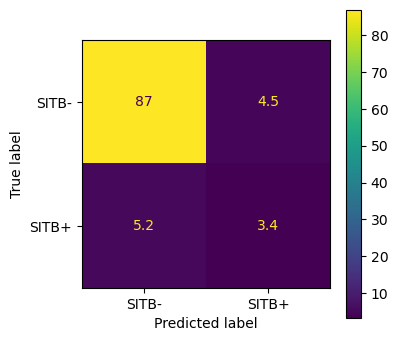

In [300]:
%%time
text_features = 'content'

ts_i = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')


vectorizer = TfidfVectorizer(analyzer='word', binary=False,
                 decode_error='strict',
                 encoding='utf-8', input='content',
                 lowercase=True, max_df=0.8, max_features=None,
                 min_df=3, ngram_range=(1,2), norm='l2',
                 preprocessor=preprocess, smooth_idf=True,
                 stop_words=stopwords.words('english'), strip_accents='unicode',
                 sublinear_tf=True,
                 token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=custom_tokenizer, use_idf=True,
                 vocabulary=None)


model = LGBMClassifier(class_weight="balanced",random_state=SEED_VALUE)




# t_clf = Pipeline(
#       [
#           ("vectorizer",vectorizer),
#         ("balancer", SMOTE(random_state=123)),
#           ("lgbm", model)
#       ])


t_clf = imb_Pipeline([
     ('vectorizer', vectorizer),
     # ('balancer', SMOTE(random_state=123)),
         ('balancer', SMOTETomek(random_state=123)),
     ('lgbm', model), # this is class_weight='balanced'
    ])

                      
# see all parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html
# https://datascience.stackexchange.com/questions/108233/recommendations-for-tuning-xgboost-hyperparams

# get cross validation split indexes
iterable_train_val_indexes = []
for train_i, val_i in kf.split(X_train_text):
    iterable_train_val_indexes.append((train_i,val_i))

text_grid_search = GridSearchCV(t_clf, param_grid, cv=iterable_train_val_indexes, scoring=["f1"],refit="f1", n_jobs=-1)
text_grid_search.fit(X_train_text,y_train)


print(text_grid_search.best_score_, text_grid_search.best_params_)

# need to add estimator to parameter names 

# retrain with best params and evaluate on test set
results = save_results_df(text_grid_search,X_train_text,y_train,X_test_text,y_test,
                          model_name='lgbm_text',
                         output_dir=output_dir_i, ts = ts_i)

for k, v in results.get('lgbm_text').items():
    print(k) 
    display(v)
    print()

In [301]:
print(text_grid_search.best_score_, text_grid_search.best_params_)

0.6526361435065077 {'lgbm__colsample_bytree': 0.5, 'lgbm__max_depth': -1, 'lgbm__min_child_samples': 20, 'lgbm__min_child_weight': 0.01, 'vectorizer__max_features': None}


# Text + Metadata model

In [ ]:
toy = False

if toy:
    print('WARNING, running toy version')
    param_grid = {
       'preprocessor__text__vectorizer__max_features': [2000, None],
        'lgbm__min_child_samples': [10, 20,40], #alias: min_data_in_leaf

    }
else:
    param_grid = {
        'preprocessor__text__vectorizer__max_features': [2000, None],
        'lgbm__colsample_bytree': [1, 0.5, 0.1],
        'lgbm__max_depth': [-1,10,20], #-1 is the default and means No max depth
        'lgbm__min_child_weight': [0.01, 0.001, 0.0001],
        'lgbm__min_child_samples': [10, 20,40], #alias: min_data_in_leaf

    }

In [249]:
%%time


ts_i = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')

numeric_features = ['contact_size','reputation','type']
text_features = 'type_tag_content'

# get cross validation split indexes
iterable_train_val_indexes = []
for train_i, val_i in kf.split(X_train_metadata):
    iterable_train_val_indexes.append((train_i,val_i))
    
# Define pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

text_transformer = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(analyzer='word', binary=False,
                 decode_error='strict',
                 encoding='utf-8', input='content',
                 lowercase=True, max_df=0.8, max_features=20000,
                 min_df=3, ngram_range=(1, 2), norm='l2',
                 preprocessor=preprocess, smooth_idf=True,
                 stop_words=stopwords.words('english'), strip_accents='unicode',
                 sublinear_tf=True,
                 token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=custom_tokenizer, use_idf=True,
                 vocabulary=None))])
    
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('text', text_transformer, text_features)])
    
mnt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('lgbm', LGBMClassifier(class_weight="balanced",random_state=SEED_VALUE, max_depth=20, min_child_samples=20, num_leaves=31, colsample_bytree=.95))
                     ])





meta_num_text_grid_search = GridSearchCV(mnt_clf, param_grid, cv=iterable_train_val_indexes, scoring=["f1"],refit="f1", n_jobs=-1)
meta_num_text_grid_search.fit(X_train_metadata,y_train)

# need to add estimator to parameter names 
best_params = {}
for k,v in meta_num_text_grid_search.best_params_.items():
    best_params['estimator__'+k] = v


# retrain with best params and evaluate on test set
results = save_results_df(meta_num_text_grid_search,best_params,X_train_metadata,y_train,X_test_metadata,y_test,
                          model_name='lgbm_metadata',
                         output_dir=output_dir_i, ts = ts_i)

for k, v in results.get('lgbm_metadata').items():
    print(k) 
    display(v)
    print()

KeyboardInterrupt: 